# Computación Paralela
## Multiplicación de matrices

*María Graciel Cruz Cáceres*

*Departamento de Ciencia de la Computación*
*Universidad Católica San Pablo*
*Arequipa - Perú*

## Enlace al repositorio
[Github](https://github.com/magrcruz/ComputacionParalela/tree/main/MatrixMultiplicationCUDA) - https://github.com/magrcruz/ComputacionParalela/tree/main/MatrixMultiplicationCUDA

## Codigos completos

### Multiplicacion de matrices normal

In [10]:
%%writefile matmul.cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include <math.h>
#include <stdio.h>
#include <time.h>
#include <iostream>
#include <stdlib.h>
#include "GpuTimer.h"
using namespace std;

#define BLOCK_SIZE 16

void matMulCPU(float* A, float* B, float* C, int numARows, int numACols, int numBCols) {
    int i, j, k;
    int offsetA, offsetB;
    float cumSum;

    for (i = 0; i < numARows; i++) {
        for (j = 0; j < numBCols; j++) {
            cumSum = 0;
            for (k = 0; k < numACols; k++) {
                // linearize index
                offsetA = i*numACols + k;
                offsetB = k*numBCols + j;

                // accumulate element-wise product
                cumSum += A[offsetA] * B[offsetB];
            }
            C[i*numBCols + j] = cumSum;
        }
    }
}

__global__ void matMulGPU(float* A, float* B, float* C, int numARows, int numACols, int numBCols) {
    // compute global thread coordinates
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    // linearize coordinates for data access
    int offset = row * numBCols + col;

    if ((row < numARows) && (col < numBCols)) {
        float cumSum = 0;
        for (int k = 0; k < numACols; k++) {
            cumSum += A[row*numACols + k] * B[k*numBCols + col];
        }
        C[offset] = cumSum;
    }
}


int main(int argc, char* argv[]) {
    int numARows = 960;
    int numACols = 640;
    int numBCols = 800;

    if (argc ==4 ) {
        numARows = std::stoi(argv[1]);
        numACols = std::stoi(argv[2]);
        numBCols = std::stoi(argv[3]);
    }

    cout<<"Size of matrix A: "<<numARows<<" "<<numACols<<endl;
    cout<<"Size of matrix B: "<<numACols<<" "<<numBCols<<endl;

    // timers
    GpuTimer timer0, timer1, timer2, timer3;

    size_t sizeA = numARows * numACols * sizeof(float);
    size_t sizeB = numACols * numBCols * sizeof(float);
    size_t sizeC = numARows * numBCols * sizeof(float);


    // allocate host memory
    float* h_A = (float*)malloc(sizeA);
    float* h_B = (float*)malloc(sizeB);
    float* h_C = (float*)malloc(sizeC);
    float* h_C_CPU = (float*)malloc(sizeC);

    // initialize host matrices
    int i, j, offset;
    for (i = 0; i <  numARows; i++) {
        for (j = 0; j < numACols; j++) {
            offset = i*numACols + j;
            h_A[offset] = sin(i);
        }
    }
    for (i = 0; i <  numACols; i++) {
        for (j = 0; j < numBCols; j++) {
            offset = i*numBCols + j;
            h_B[offset] = cos(j);
        }
    }

    // allocate device matrices
    float* d_A;
    float* d_B;
    float* d_C;
    timer0.Start();
    cudaMalloc((void**)&d_A, sizeA);
    cudaMalloc((void**)&d_B, sizeB);
    cudaMalloc((void**)&d_C, sizeC);
    timer0.Stop();
    printf("Time to allocate memory on the device is: %f msecs.\n", timer0.Elapsed());

    // transfer to GPU
    timer1.Start();
    cudaMemcpy(d_A, h_A, sizeA, cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, h_B, sizeB, cudaMemcpyHostToDevice);
    timer1.Stop();
    printf("Time to copy the Matrix from host to device is: %f msecs.\n", timer1.Elapsed());

    // kernel launch
    dim3 threadPerBlock(BLOCK_SIZE, BLOCK_SIZE, 1);
    dim3 blockPerGrid(ceil(numBCols/(float)BLOCK_SIZE), ceil(numACols/(float)BLOCK_SIZE), 1);
    timer2.Start();
    matMulGPU<<<blockPerGrid, threadPerBlock>>>(d_A, d_B, d_C, numARows, numACols, numBCols);
    timer2.Stop();
    printf("Implemented CUDA code ran in: %f msecs.\n", timer2.Elapsed());

    // transfer to CPU
    timer3.Start();
    cudaMemcpy(h_C, d_C, sizeC, cudaMemcpyDeviceToHost);
    timer3.Stop();
    printf("Time to copy the resulting Matrix from device to host is: %f msecs.\n", timer3.Elapsed());

    clock_t begin = clock();
    matMulCPU(h_A, h_B, h_C_CPU, numARows, numACols, numBCols);
    clock_t end = clock();
    double time_spent = (double)(end - begin) / CLOCKS_PER_SEC * 1000;
    printf("Implemented CPU code ran in: %f msecs.\n", time_spent);

    free(h_A); free(h_B); free(h_C); free(h_C_CPU);
    cudaFree(d_A); cudaFree(d_B); cudaFree(d_C);
    printf("Done");

    return 0;
}

Writing matmul.cu


### Multiplicacion de matrices tiled

In [11]:
%%writefile matmulTiled.cu
#include "cuda_runtime.h"
#include "device_launch_parameters.h"
#include <math.h>
#include <stdio.h>
#include <time.h>
#include <iostream>
#include <stdlib.h>
#include "GpuTimer.h"
using namespace std;

#define BLOCK_SIZE 16
#define TILE_WIDTH 16

void matMulCPU(float* A, float* B, float* C, int numARows, int numACols, int numBCols) {
    int i, j, k;
    int offsetA, offsetB;
    float cumSum;

    for (i = 0; i < numARows; i++) {
        for (j = 0; j < numBCols; j++) {
            cumSum = 0;
            for (k = 0; k < numACols; k++) {
                // linearize index
                offsetA = i*numACols + k;
                offsetB = k*numBCols + j;

                // accumulate element-wise product
                cumSum += A[offsetA] * B[offsetB];
            }
            C[i*numBCols + j] = cumSum;
        }
    }
}

__global__ void matMulGPU(float* A, float* B, float* C, int numARows, int numACols, int numBCols) {
    // allocate shared memory
    __shared__ float sharedA[TILE_WIDTH][TILE_WIDTH];
    __shared__ float sharedB[TILE_WIDTH][TILE_WIDTH];

    int bx = blockIdx.x; int by = blockIdx.y;
    int tx = threadIdx.x; int ty = threadIdx.y;

    // coordinates for C
    int row = by * TILE_WIDTH + ty;
    int col = bx * TILE_WIDTH + tx;

    float cumSum = 0;
    for (int m = 0; m < ceil(numACols/(float)TILE_WIDTH); m++) {
        // load tiles
        if ((row < numARows) && ((m*TILE_WIDTH + tx) < numACols))
            sharedA[ty][tx] = A[row*numACols + m*TILE_WIDTH + tx];
        else
            sharedA[ty][tx] = 0;
        if ((col < numBCols) && ((m*TILE_WIDTH + ty) < numACols))
            sharedB[ty][tx] = B[(m*TILE_WIDTH + ty)*numBCols + col];
        else
            sharedB[ty][tx] = 0;
        // pause until all threads have loaded tile values
        __syncthreads();

        // compute partial dot product (for individual thread)
        for (int k = 0; k < TILE_WIDTH; k++) {
            cumSum += sharedA[ty][k] * sharedB[k][tx];
        }
        // wait until all threads have used tile values
        __syncthreads();
    }
    if((row < numACols) && (col < numBCols)) {
        C[row*numBCols + col] = cumSum;
    }
}


int main(int argc, char* argv[]) {
    int numARows = 960;
    int numACols = 640;
    int numBCols = 800;

    if (argc == 4) {
        numARows = std::stoi(argv[1]);
        numACols = std::stoi(argv[2]);
        numBCols = std::stoi(argv[3]);
    }

    cout<<"Size of matrix A: "<<numARows<<" "<<numACols<<endl;
    cout<<"Size of matrix B: "<<numACols<<" "<<numBCols<<endl;

    // timers
    GpuTimer timer0, timer1, timer2, timer3;

    size_t sizeA = numARows * numACols * sizeof(float);
    size_t sizeB = numACols * numBCols * sizeof(float);
    size_t sizeC = numARows * numBCols * sizeof(float);

    // allocate host memory
    float* h_A = (float*)malloc(sizeA);
    float* h_B = (float*)malloc(sizeB);
    float* h_C = (float*)malloc(sizeC);
    float* h_C_CPU = (float*)malloc(sizeC);

    // initialize host matrices
    int i, j, offset;
    for (i = 0; i <  numARows; i++) {
        for (j = 0; j < numACols; j++) {
            offset = i*numACols + j;
            h_A[offset] = sin(i);
        }
    }
    for (i = 0; i <  numACols; i++) {
        for (j = 0; j < numBCols; j++) {
            offset = i*numBCols + j;
            h_B[offset] = cos(j);
        }
    }

    // allocate device matrices
    float* d_A;
    float* d_B;
    float* d_C;
    timer0.Start();
    cudaMalloc((void**)&d_A, sizeA);
    cudaMalloc((void**)&d_B, sizeB);
    cudaMalloc((void**)&d_C, sizeC);
    timer0.Stop();
    printf("Time to allocate memory on the device is: %f msecs.\n", timer0.Elapsed());

    // transfer to GPU
    timer1.Start();
    cudaMemcpy(d_A, h_A, sizeA, cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, h_B, sizeB, cudaMemcpyHostToDevice);
    timer1.Stop();
    printf("Time to copy the Matrix from host to device is: %f msecs.\n", timer1.Elapsed());

    // kernel launch
    dim3 threadPerBlock(BLOCK_SIZE, BLOCK_SIZE, 1);
    dim3 blockPerGrid(ceil(numBCols/(float)BLOCK_SIZE), ceil(numACols/(float)BLOCK_SIZE), 1);
    timer2.Start();
    matMulGPU<<<blockPerGrid, threadPerBlock>>>(d_A, d_B, d_C, numARows, numACols, numBCols);
    timer2.Stop();
    printf("Implemented CUDA code ran in: %f msecs.\n", timer2.Elapsed());

    // transfer to CPU
    timer3.Start();
    cudaMemcpy(h_C, d_C, sizeC, cudaMemcpyDeviceToHost);
    timer3.Stop();
    printf("Time to copy the resulting Matrix from device to host is: %f msecs.\n", timer3.Elapsed());

    clock_t begin = clock();
    matMulCPU(h_A, h_B, h_C_CPU, numARows, numACols, numBCols);
    clock_t end = clock();
    double time_spent = (double)(end - begin) / CLOCKS_PER_SEC * 1000;
    printf("Implemented CPU code ran in: %f msecs.\n", time_spent);

    free(h_A); free(h_B); free(h_C); free(h_C_CPU);
    cudaFree(d_A); cudaFree(d_B); cudaFree(d_C);

    return 0;
}

Writing matmulTiled.cu


### Timer para medir ejecucion en cuda

In [12]:
# Archivo para tomar tiempos
%%writefile GpuTimer.h
#ifndef __GPU_TIMER_H__
#define __GPU_TIMER_H__

struct GpuTimer{
      cudaEvent_t start;
      cudaEvent_t stop;

      GpuTimer(){
            cudaEventCreate(&start);
            cudaEventCreate(&stop);
      }

      ~GpuTimer(){
            cudaEventDestroy(start);
            cudaEventDestroy(stop);
      }

      void Start(){cudaEventRecord(start, 0);}

      void Stop(){cudaEventRecord(stop, 0);}

      float Elapsed(){
            float elapsed;
            cudaEventSynchronize(stop);
            cudaEventElapsedTime(&elapsed, start, stop);
            return elapsed;
      }
};

#endif  /* __GPU_TIMER_H__ */

Writing GpuTimer.h


### Script para ejecutar algunos experimentos

In [13]:
%%writefile runExperiment.sh
#!/bin/bash

# Parámetros de la lista a, b y c
a=(1080 1440 1800 2160 2520 2880 3240 3600 3960 4320)
b=(720 960 1200 1440 1680 1920 2160 2400 2640 2880)
c=(900 1200 1500 1800 2100 2400 2700 3000 3300 3600)

# Número de iteraciones
n=5

# Ejecutar matmul n veces con diferentes parámetros
for ((i=1; i<=$n; i++))
do
  # Obtener los parámetros para la iteración actual
  param_a=${a[$((i % ${#a[@]}))]}
  param_b=${b[$((i % ${#b[@]}))]}
  param_c=${c[$((i % ${#c[@]}))]}

  # Ejecutar el programa matmul con los parámetros actuales
  output=$(./matmul $param_a $param_b $param_c)

  # Extraer el tiempo de ejecución de CUDA
  cuda_time=$(echo "$output" | grep -oE 'Implemented CUDA code ran in: [0-9.]+ msecs.' | awk '{print $6}')

  # Extraer el tiempo de ejecución de la CPU
  cpu_time=$(echo "$output" | grep -oE 'Implemented CPU code ran in: [0-9.]+ msecs.' | awk '{print $6}')

  # Ejecutar el programa matmul con los parámetros actuales
  output=$(./matmulTiled $param_a $param_b $param_c)

  # Extraer el tiempo de ejecución de CUDA
  cudaT_time=$(echo "$output" | grep -oE 'Implemented CUDA code ran in: [0-9.]+ msecs.' | awk '{print $6}')

  # Extraer el tiempo de ejecución de la CPU
  cpuT_time=$(echo "$output" | grep -oE 'Implemented CPU code ran in: [0-9.]+ msecs.' | awk '{print $6}')

  # Imprimir los resultados
  echo "$i: $cuda_time $cpu_time $cudaT_time $cpuT_time"
done

Writing runExperiment.sh


### Resultados ya calculados

In [14]:
%%writefile output.txt
1: 7.780960 5283.247000 4.754688 5385.001000
2: 12.743456 11217.220000 9.397920 11594.978000
3: 26.355295 23999.709000 16.505344 23775.906000
4: 35.171200 49055.120000 25.694719 48780.736000
5: 61.948929 69262.638000 38.748383 67728.675000

Overwriting output.txt


## Introducción
Se implementaron las técnicas para convertir una imagen a escala de grises y la aplicación de filtro blur en CUDA. Los códigos se ejecutaron en Colab

# Comprobar que CUDA este funcionando correctamente

In [15]:
# Comprobar que Cuda toolkit este instalado
!ls /usr/local

bin    cuda	cuda-11.8  games	       include	lib64	   man	 share
colab  cuda-11	etc	   _gcs_config_ops.so  lib	licensing  sbin  src


In [16]:
# Comprobar si se tiene el comando nvcc
!which nvcc

/usr/local/cuda/bin/nvcc


In [17]:
# Escribir archivo hello world para cuda
%%writefile hello.cu

#include <cstdio>
#include <cuda.h>
__global__ void hello(void)
{
  printf("GPU: Hello!\n");
}
int main(int argc,char **argv)
{
  printf("CPU: Hello!\n");
  hello<<<1,10>>>();
  cudaDeviceReset();
  return 0;
}


Writing hello.cu


In [18]:
# Compilar hello.cu
!nvcc -arch=sm_37 -gencode=arch=compute_37,code=sm_37 hello.cu -o hello

nvcc warning : The 'compute_35', 'compute_37', 'sm_35', and 'sm_37' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).


In [19]:
# Ejecutar programa
!./hello

CPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!


Cuda esta funcionando correctamente.

# Ejecucion de del codigo

### Multiplicacion de matrices

In [20]:
!nvcc matmul.cu -o matmul

In [21]:
!./matmul

Size of matrix A: 960 640
Size of matrix B: 640 800
Time to allocate memory on the device is: 0.374784 msecs.
Time to copy the Matrix from host to device is: 1.212640 msecs.
Implemented CUDA code ran in: 2.813024 msecs.
Time to copy the resulting Matrix from device to host is: 2.237152 msecs.
Implemented CPU code ran in: 3087.554000 msecs.
Done

### Multiplicacion de matrices por bloques

In [22]:
!nvcc matmulTiled.cu -o matmulTiled

In [23]:
!./matmulTiled

Size of matrix A: 960 640
Size of matrix B: 640 800
Time to allocate memory on the device is: 0.462848 msecs.
Time to copy the Matrix from host to device is: 1.240704 msecs.
Implemented CUDA code ran in: 1.786080 msecs.
Time to copy the resulting Matrix from device to host is: 2.485376 msecs.
Implemented CPU code ran in: 3331.978000 msecs.


# Explicación del código

Se ejecutan 2 implementaciones para realizar la comparacion de tiempos de la multiplicacion de matrices, uno en CPU y otro en GPU

## Mutliplicacion de matrices

### Multiplicacion en CPU

La multiplicacion en CPU es la multiplicación clásica, por se multiplica cada fila por cada columna las cuales se acumulan en el bucle interior.

```cpp
void matMulCPU(float* A, float* B, float* C, int numARows, int numACols, int numBCols) {
    int i, j, k;
    int offsetA, offsetB;
    float cumSum;

    for (i = 0; i < numARows; i++) {
        for (j = 0; j < numBCols; j++) {
            cumSum = 0;
            for (k = 0; k < numACols; k++) {
                // linearize index
                offsetA = i*numACols + k;
                offsetB = k*numBCols + j;

                // accumulate element-wise product
                cumSum += A[offsetA] * B[offsetB];
            }
            C[i*numBCols + j] = cumSum;
        }
    }
}
```
En el main se ejecuta de manera trivial, llamando a la función.

### Multiplicacion en GPU

Se realiza la multiplicacion en el GPU, se utiliza `__global__` para indicar que se ejecuta en el GPU, recibe como en la anterior funcion las matrices A, B y C junto con sus tamaños.

```cpp
__global__ void matMulGPU(float* A, float* B, float* C, int numARows, int numACols, int numBCols) {

```

En este caso calcula la posicion de los indices basado en el indice y dimension del bloque.

```cpp
    // compute global thread coordinates
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    // linearize coordinates for data access
    int offset = row * numBCols + col;
```
Y finalmente realiza la operacion normalmente, pero cuidando de no salirse del rango de la matriz

```cpp
    if ((row < numARows) && (col < numBCols)) {
        float cumSum = 0;
        for (int k = 0; k < numACols; k++) {
            cumSum += A[row*numACols + k] * B[k*numBCols + col];
        }
        C[offset] = cumSum;
    }
}
```

### Multiplicación de matrices por bloques o tiled

La multiplicación en GPU se realiza de la siguiente manera:

Con el indicador `__global__` se ejecutara en el device, recibe igualmente las matrices con sus respectivos tamaños

```cpp
__global__ void matMulGPU(float* A, float* B, float* C, int numARows, int numACols, int numBCols) {
```
Para la multiplicación de matrices tiled utilizaremos memoria compartida en cuda, esta se declara con el indicador `__shared__` para que todos los threads dentro del bloque puedan acceder
```cpp

    // allocate shared memory
    __shared__ float sharedA[TILE_WIDTH][TILE_WIDTH];
    __shared__ float sharedB[TILE_WIDTH][TILE_WIDTH];
```
Calculamos las coordenadas a partir del indice del thread, del bloque y el tamaño del TILE
```cpp
    int bx = blockIdx.x;
    int by = blockIdx.y;
    int tx = threadIdx.x;
    int ty = threadIdx.y;

    // coordinates for C
    int row = by * TILE_WIDTH + ty;
    int col = bx * TILE_WIDTH + tx;

    float cumSum = 0;
```
Realizara el calculo dentro del tiled o bloque designado. Realiza las fases. Cada thread colabora para subir a memoria compartida los elementos que le corresponden al bloque. Un thread cargaría el elemento en M,N
```cpp
    for (int m = 0; m < ceil(numACols/(float)TILE_WIDTH); m++) {
        // load tiles
        if ((row < numARows) && ((m*TILE_WIDTH + tx) < numACols))
            sharedA[ty][tx] = A[row*numACols + m*TILE_WIDTH + tx];
        else
            sharedA[ty][tx] = 0;
        if ((col < numBCols) && ((m*TILE_WIDTH + ty) < numACols))
            sharedB[ty][tx] = B[(m*TILE_WIDTH + ty)*numBCols + col];
        else
            sharedB[ty][tx] = 0;
        // pause until all threads have loaded tile values
        __syncthreads();
```
Calculamos el producto punto parcial en cumSum, es una variable privada del tread para despues guardar su valor.
```cpp
        // compute partial dot product (for individual thread)
        for (int k = 0; k < TILE_WIDTH; k++) {
            cumSum += sharedA[ty][k] * sharedB[k][tx];
        }
        // wait until all threads have used tile values
        __syncthreads();
    }
    if((row < numACols) && (col < numBCols)) {
        C[row*numBCols + col] = cumSum;
    }
}
```

### Inicializacion de valores en main

Calcula el tamaño que necesita para almacenar los valores de las matrice
```cpp
    size_t sizeA = numARows * numACols * sizeof(float);
    size_t sizeB = numACols * numBCols * sizeof(float);
    size_t sizeC = numARows * numBCols * sizeof(float);
```
Reserva la memoria en el host
```cpp
    // allocate host memory
    float* h_A = (float*)malloc(sizeA);
    float* h_B = (float*)malloc(sizeB);
    float* h_C = (float*)malloc(sizeC);
    float* h_C_CPU = (float*)malloc(sizeC);
```
Y los inicializa
```cpp
    // initialize host matrices
    int i, j, offset;
    for (i = 0; i <  numARows; i++) {
        for (j = 0; j < numACols; j++) {
            offset = i*numACols + j;
            h_A[offset] = sin(i);
        }
    }
    for (i = 0; i <  numACols; i++) {
        for (j = 0; j < numBCols; j++) {
            offset = i*numBCols + j;
            h_B[offset] = cos(j);
        }
    }
```

### Ejecucion en GPU


Para ejecutar el codigo en GPU lo primero que debemos hacer es asignar memoria en el device con `cudaMalloc`, lo almacena en los punteros definidos con los tamaños previamente calculados.
```cpp
    // allocate device matrices
    float* d_A;
    float* d_B;
    float* d_C;
    timer0.Start();
    cudaMalloc((void**)&d_A, sizeA);
    cudaMalloc((void**)&d_B, sizeB);
    cudaMalloc((void**)&d_C, sizeC);
    timer0.Stop();
    printf("Time to allocate memory on the device is: %f msecs.\n", timer0.Elapsed());
```
Ahora tiene que enviar la información al GPU, lo realiza con `cudaMemcpy` donde `d_A` es el destino, `h_A` el origen, `sizeA` el tamaño y `cudaMemcpyHostToDevice` es el tipo de operación de copia que indica que va del device al host.
```cpp
    // transfer to GPU
    timer1.Start();
    cudaMemcpy(d_A, h_A, sizeA, cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, h_B, sizeB, cudaMemcpyHostToDevice);
    timer1.Stop();
    printf("Time to copy the Matrix from host to device is: %f msecs.\n", timer1.Elapsed());
```
Define la cantidad de threads que estarán en cada bloque `threadPerBlock` y la cantidad de bloques `blockPerGrid`.

Invoca a la funcion con los parámetros ya indicados.

```cpp
    // kernel launch
    dim3 threadPerBlock(BLOCK_SIZE, BLOCK_SIZE, 1);
    dim3 blockPerGrid(ceil(numBCols/(float)BLOCK_SIZE), ceil(numACols/(float)BLOCK_SIZE), 1);
    timer2.Start();
    matMulGPU<<<blockPerGrid, threadPerBlock>>>(d_A, d_B, d_C, numARows, numACols, numBCols);
    timer2.Stop();
    printf("Implemented CUDA code ran in: %f msecs.\n", timer2.Elapsed());
```
Y finalmente copia de regreso los valores del device al host.
```cpp
    // transfer to CPU
    timer3.Start();
    cudaMemcpy(h_C, d_C, sizeC, cudaMemcpyDeviceToHost);
    timer3.Stop();
    printf("Time to copy the resulting Matrix from device to host is: %f msecs.\n", timer3.Elapsed());
```
Al final de realizar las operaciones se libera la memoria
```cpp
    cudaFree(d_A); cudaFree(d_B); cudaFree(d_C);
```

# Ejecución del experimento

Los tamaños de la matriz escogidos son mayores a 500, van de 360 a 360 y son multiplos de 3, 4 y 5

In [24]:
!./runExperiment.sh >> output.txt

/bin/bash: ./runExperiment.sh: Permission denied


##Visualizacion del resultado

Text(0, 0.5, 'Tiempo log(msec)')

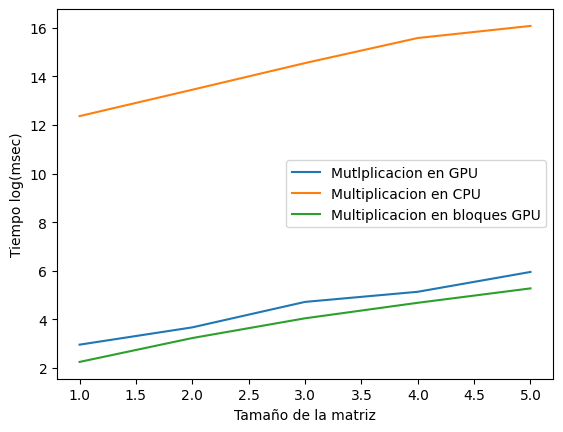

In [28]:
import matplotlib.pyplot as plt
import math
# Leer datos del archivo
tiempos = []
valores1 = []
valores2 = []
valores3 = []

with open("output.txt", "r") as archivo:
    for linea in archivo:
        partes = linea.split()
        tiempos.append(int(partes[0].strip(':')))
        valores1.append(math.log(float(partes[1]),2))
        valores2.append(math.log(float(partes[2]),2))
        valores3.append(math.log(float(partes[3]),2))

# Graficar los datos
plt.plot(tiempos, valores1, label='Mutlplicacion en GPU')
plt.plot(tiempos, valores2, label='Multiplicacion en CPU')
plt.plot(tiempos, valores3, label='Multiplicacion en bloques GPU')

# Configurar la leyenda y los ejes
plt.legend()
plt.xlabel('Tamaño de la matriz')
plt.ylabel('Tiempo log(msec)')

# Mostrar el gráfico
plt.show()

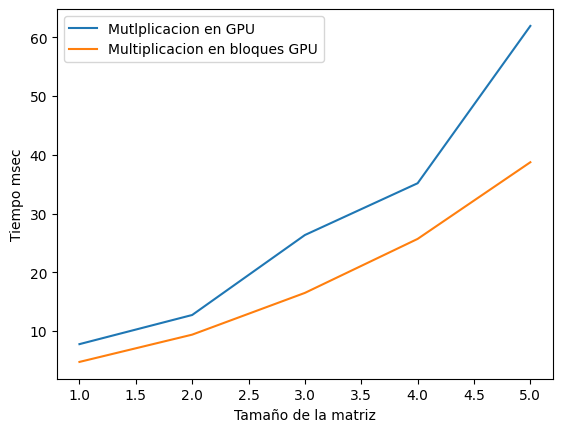

In [27]:
import matplotlib.pyplot as plt
# Leer datos del archivo
tiempos = []
valores1 = []
valores3 = []

with open("output.txt", "r") as archivo:
    for linea in archivo:
        partes = linea.split()
        tiempos.append(int(partes[0].strip(':')))
        valores1.append(float(partes[1]))
        valores3.append(float(partes[3]))

# Graficar los datos
plt.plot(tiempos, valores1, label='Mutlplicacion en GPU')
plt.plot(tiempos, valores3, label='Multiplicacion en bloques GPU')

# Configurar la leyenda y los ejes
plt.legend()
plt.xlabel('Tamaño de la matriz')
plt.ylabel('Tiempo msec')

# Mostrar el gráfico
plt.show()


Podemos observar que la ejecución en GPU es bastante rápida, se graficó aplicando logaritmo al tiempo ya que la velocidad de la ejecución en CPU era mucho mayor y no dejaba mucho espacio para diferenciar el tiempo de ejecución de la multiplicación en GPU y por bloques en GPU.

El código más rapido es la mutliplicación por bloques en CUDA, le sigue la multiplicación por bloques y finalmente la ejecución en el CPU.